Cleaned up version of makemore MLP implementation (for V1 - look at MLP notebook)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
#Loading our data
words = open(r'dataset\names.txt',mode='r').read().splitlines()
words[:10]
len(words)

32033

In [3]:
#charset
chars = sorted(list(set(''.join(words))))
S_to_I = {s:i+1 for i,s in enumerate(chars)}
S_to_I['.'] = 0
I_to_S = {i:s for s,i in S_to_I.items()}
vocab_size  = len(I_to_S)

print(I_to_S,'\n', vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'} 
 27


In [4]:
block_size = 3
def build_dataset(words):
    X, Y = [],[]
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w +'.':
            ix = S_to_I[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(I_to_S[i] for i in context), '----->', I_to_S[ix])
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 *len(words))
n2 = int(0.9*len(words))

X_train, y_train = build_dataset(words[n1:])
X_valid, y_valid = build_dataset(words[n1:n2])
X_test , y_test = build_dataset(words[n2:])


Parameters (outside of functional code block for easier interpretability and maintenance)

In [5]:
n_emb = 10 #Number of dimensions for character embeddings
n_hidden = 300 #Number of neurons in our Hidden tanh layer
g =  torch.Generator().manual_seed(2147483647) # Set seed for reproducability
C = torch.randn([vocab_size,n_emb], generator=g) #Our embedding table
w1 = torch.randn([(n_emb* block_size),n_hidden],    generator=g) / (5/3)/(((n_emb*block_size)**0.5)) #*0.2 #created weights1 init to randn tensor with shape ( from our embedding, and 100 outputs as per our hyperparameter)
b1 = torch.randn((n_hidden),    generator=g) * 0.01
w2 = torch.randn([n_hidden,vocab_size],     generator=g) * 0.01 #created weights2 init to randn tensor with shape (100 as outputs from prev layer tanh, and 27 outputs as per our 'possible' charset)
b2 = torch.randn((vocab_size),  generator=g) * 0 #At init, we set our b2 to zero, so we do not influence our logits and have a more even dist in the logits to record a lower init loss.

#BatchNorm Parameters
bN_gain = torch.ones((1,n_hidden)) #Batch Norm gain applied to scale and shift normalized batch, and allow network to backprop and adjust weights to move the normalized batch accordingly.
bN_bias = torch.zeros((1,n_hidden)) #Batch Norm bias applied to similarly to Batch Norm gain above.
bNmean_running = torch.zeros((1,n_hidden)) #bNmean running init to zero, as per our gaussian distribution.
bNstd_running = torch.ones((1,n_hidden)) #bNstd running init to one, as per our gaussian distribution.
#-------------------

params = [C, w1, b1, w2, b2, bN_gain, bN_bias] #created new params variable to hold all Parameters as a list, so we can calculate total parameters in our network
for p in params:
    p.requires_grad = True

In [6]:
print(f'{sum(p.nelement() for p in params)} parameters')

18297 parameters


In [26]:
step_size = 100000
batch_size = 64
loss_acq = []
for i in range(step_size):
    #Minibatch from dataset
    ix = torch.randint(0,X_train.shape[0], (batch_size, ),    generator=g) 
    Xtr, Ytr = X_train[ix], y_train[ix]
    
    #Forward pass
    emb = C[Xtr] #Embedding vector
    embcat = emb.view(emb.shape[0],-1) #Joined embedding to have same number of dimensions as w1 for matrix muliplication
    h_preact = (embcat @ w1) #+ b1 # ---Side note, no need to have bias when using BatchNorm, esp BatchNorm in place with training, as bias is controlled by the BatchNorm bias
    bNmean_i = h_preact.mean(0,keepdim=True) #BatchNorm mean at i iteration in the training
    bNstd_i = h_preact.std(0, keepdim=True) #BatchNorm std at i iteration in the training
    
    h_preact_bN = bN_gain * (h_preact - bNmean_i )/bNstd_i + bN_bias #BatchNormalization layer, added before hidden tanh/activation layer, - added bNmean_i and bNstd_i for bNmean & bNstd calibration.
    
    with torch.no_grad():
        bNmean_running = 0.99 * bNmean_i + 0.001 * bNmean_running
        bNstd_running = 0.99 * bNstd_i + 0.001 * bNstd_running
    
    h = torch.tanh(h_preact_bN)
    logits = h @ w2 +b2
    #counts = logits.exp()
    #prob = counts / counts.sum(dim=1, keepdim=True)
    #loss = -prob[torch.arange(16),Y].log().mean()
    loss = F.cross_entropy(logits, Ytr)
    
    #Backward pass
    for p in params:
        p.grad =None
    loss.backward()
    #learning rate adjust
    #lr = learn_step[i]
    #Update
    lr= 0.1 if i < 50000 else 0.01
    for p in params:
        p.data += -lr * p.grad
    #learning rate tracking
    #learn_used.append(learn_exp[i])
    if i % 10000 == 0:
        print(f'{i:7d}/{step_size:7d}: {loss.item():.4f}')
    loss_acq.append(loss.log10().item())
    break
        
print(loss.item())

      0/ 100000: 3.3112
  10000/ 100000: 2.0707
  20000/ 100000: 1.8647
  30000/ 100000: 2.1928
  40000/ 100000: 1.9839
  50000/ 100000: 2.3732
  60000/ 100000: 1.8674
  70000/ 100000: 1.7613
  80000/ 100000: 1.8196
  90000/ 100000: 2.0648
1.7736772298812866


torch.Size([1, 300])

In [ ]:
#plt.figure(figsize=(20,10))
#plt.imshow(h.abs() > 0.99, cmap='grey', interpolation='nearest')

In [ ]:
#plt.hist(h.view(-1).tolist(),50);

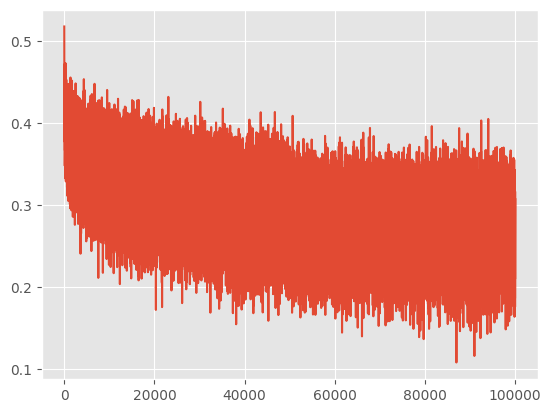

In [18]:
plt.plot(loss_acq);

Note that calibration below can be done in running with the network training iteration - Only kept in here as note

In [23]:
#Calibrate the bN mean & std at the end of training
with torch.no_grad():
    emb = C[X_train]
    embcat = emb.view(emb.shape[0],-1)
    h_preact = embcat @ w1 + b1
#measure/calc the mean & std over the entire training set
    bN_mean = h_preact.mean(0,keepdim=True)
    bN_std = h_preact.std(0, keepdim=True)

Train and Validation split loss

In [24]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, y_train),
        'valid': (X_valid, y_valid),
        'test': (X_test, y_test)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0],-1)
    h_preact = (embcat @ w1) + b1
    h_preact_bN = bN_gain * (h_preact - bNmean_running)/ bNstd_running + bN_bias
    h = torch.tanh(h_preact_bN)
    logits = h @ w2 +b2
    #counts = logits.exp()
    #prob = counts / counts.sum(dim=1, keepdim=True)
    #loss = -prob[torch.arange(16),Y].log().mean()
    loss = F.cross_entropy(logits, y)
    print(split,'loss:', loss.item())
    
split_loss('train')
split_loss('valid')


train loss: 3.2584645748138428
valid loss: 3.2588956356048584


Sampling from the model

In [18]:
for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0],-1)
        h = torch.tanh((embcat @ w1) + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        
    print(''.join(I_to_S[i] for i in out))

grabetzmaton.
xegh.
quriffryne.
whegvinggupfred.
kylynnnsh.
gdwfploddp.
xvvedhmen.
doxqing.
ktexgenfxwer.
qujfatton.
fawguguffuddh.
wwy.
wyxpi.
xfmpseus.
xhe.
cubabkumwnnvyfferonquyphioshfrdev.
juwafguchanvonguss.
chragriq.
blyk.
grychiamberly.


PyTorchfied Summary code of BatchNorm and Activation layers

In [12]:
from typing import Any


class Linear:
    def __init__(self, fan_in, fan_out, bias=True): #This is us initializing our linear layer ( Weight * input + bias) (Note we init our weight and bias, and our function takes fan_in & fan_out as args (input and output features))
        self.weight = torch.randn(fan_in, fan_out, generator=g) / fan_in**0.5 #fan_in is just input features (in our code it is the number of embeddings*block size)(self.weight == w1 in our code above)
        self.bias = torch.zeros(fan_out) if bias else None #self-explanatory, it is the bias init to zeros
    
    def __call__(self,x): #Here we define what should happen when we call our linear layer
        self.out = x @ self.weight #Matrix multiplcation as above our logits_preact layer (h_preact above)
        if self.bias is not None:
            self.out += self.bias #Here we set condition to add bias to our matrix multiplication product is bias is not None (0)
        return self.out
    
    def parameters(self): #Here we define what happens with our parameters (Weight & Bias)
        return [self.weight] + ([] if self.bias is None else [self.bias]) #Return a list of our weights and a list of our biases
    
class BatchNorm1d: #Our BatchNorm Layer
    def __init__(self, dim , eps = 1e-5, momentum=0.1): #Initializing of our batch norm layer, that takes dim, eps, momentum as args, dim is the shape/size of input our activation layer will take
        self.eps = eps
        self.momentum  = momentum
        self.training = True   #This lets our function know that we are currently training our model, hence set to true, False would be otherwise.
        
        self.gamma = torch.zeros(dim) #gamma is our BatchNorm bias, similar to our bN_bias in the code above
        self.beta = torch.ones(dim) #beta is BatchNorm gain, simliar to our bN_gain in code above
        
        self.running_mean = torch.zeros(dim) #The running mean of the batch norm function, calculated in place with the batchNorm to avoid a stage 2 computation of this stat, similar to code above
        self.running_var = torch.ones(dim)
    
    def __call__(self,x): #definig what happens when we call our BatchNorm layer (class)
        if self.training: #When in training, the following is executed
            xmean = x.mean(0, keepdims=True) #We  calculate the mean along columns (axis 0) going down, for arg x that our function takes. The shape of this mean tensor would be 1, dim of x (the batch), the mean of the batch
            xvar = x.var(0, keepdim=True) #Similar to the mean calculation above, however now we caulcate the variance, the variance of the batch
        else: #Following code is executed if we are not training the model
            xmean = self.running_mean #The mean of the batch is set to the running mean
            xvar = self.running_var #Similarly the variance of the batch is set to the running variance
        xhat = (x- xmean)/torch.sqrt(xvar+self.eps) #Normalization, ensuring the batch has a unit gaussian and 0 mean
        self.out = self.gamma + self.beta + xhat #Adding the gain and bias to our batch
        if self.training: #This code will be executed if the model is set to training
            with torch.no_grad(): #Decorator to alert Pytorch not to compute the gradients for these, as we will not backprop on them
                self.running_mean = ((1-self.momentum) * self.running_mean) + (self.momentum * xmean) #The running mean is updated with majority of what it was (0.9*r mean) and nudged (0.1) in the direction of the current mean
                self.running_var = ((1-self.momentum) * self.running_var) + (self.momentum * xvar) #Similar to the running mean update
        return self.out #Returns the output of our batch with the gain and bias
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh: #Our activation layer/class
    def __call__(self, x): #Our call function which takes our batch as an arg
        self.out = torch.tanh(x) #Applies torch.tanh to our batch and stores it as output
        return self.out #function returns the output when completed
    
    def parameters(self):
        return []
    

n_emb = 10 #Number of dimension of char embedding vectors
n_hidden = 300 #Number of neurons in hidden layer
g = torch.Generator().manual_seed(2147843647) #seed for reproducibility

C = torch.randn((vocab_size, n_emb), generator= g ) #Indexing embedding, with shape of vocab_size and n_emb

#The model, with the implementation of the classes we created. Basically functioning like torch.Linear & torch.BatchNorm layers
layers = [
    Linear(n_emb*block_size, n_hidden), Tanh(),
    Linear(n_hidden,n_hidden),Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden,n_hidden),Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad(): #decorator again, to let torch know that we will not be calling backprop on these
    layers[-1].weight *=0.1 #apply to last layer to make model less confident
    for layer in layers[:-1]:
        if isinstance(layer, Linear): #Code below is applied to Linear layers in the layers list
            layer.weight *= 5/3 #apply nonlinearity gain to our Linear layers
            

parameters = [C] + [p for layer in layers for p in layer.parameters()] #Number of parameters in our model
print(sum(p.nelement() for p in parameters), 'parameters') #num of params printed
for p in parameters:
    p.requires_grad = True #Set that parameters require gradients, so we can backprop on them
    



#Same as before modified to fit new code better
step_size = 100000
batch_size = 64
loss_acq = []

for i in range(step_size):
    #Minibatch from dataset
    ix = torch.randint(0,X_train.shape[0], (batch_size, ),    generator=g) 
    Xtr, Ytr = X_train[ix], y_train[ix]
    
    #Forward pass
    emb = C[Xtr] #Embedding vector
    x = emb.view(emb.shape[0],-1) #Joined embedding to have same number of dimensions as w1 for matrix muliplication
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x,Ytr)
    
    #Backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad =None
    loss.backward()
    
    #Update
    lr= 0.1 if i < 50000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    #Tracking stats
    if i % 10000 == 0:
        print(f'{i:7d}/{step_size:7d}: {loss.item():.4f}')
    loss_acq.append(loss.log10().item())
    #break
        
print(loss.item())
                

378897 parameters
      0/ 100000: 3.2983
  10000/ 100000: 2.2153
  20000/ 100000: 2.0614
  30000/ 100000: 1.8009
  40000/ 100000: 1.7688
  50000/ 100000: 1.7286
  60000/ 100000: 1.7739
  70000/ 100000: 1.6999
  80000/ 100000: 1.8644
  90000/ 100000: 1.7052
1.8589887619018555


Visualizations